In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.9 MB/s eta 0:00:00


In [ ]:
!pip install keras-preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 1.4 MB/s eta 0:00:00


In [ ]:
!pip install pytorch-fid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from scipy.linalg import sqrtm


!gdown --id 18WzMkgwOCZ7nzMhGM4j7fw9q6sJg4Hm7
!unzip /content/advNeuralstyleTransfer

# This chunk works.
!pip uninstall --yes gdown # After running this line, restart Colab runtime.

!pip install gdown -U --no-cache-dir

import gdown

url = 'https://drive.google.com/drive/folders/18WzMkgwOCZ7nzMhGM4j7fw9q6sJg4Hm7?usp=sharing'

gdown.download_folder(url)


/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=18WzMkgwOCZ7nzMhGM4j7fw9q6sJg4Hm7 

unzip:  cannot find or open /content/advNeuralstyleTransfer, /content/advNeuralstyleTransfer.zip or /content/advNeuralstyleTransfer.ZIP.
Found existing installation: gdown 4.6.4
Uninstalling gdown-4.6.4:
  Successfully uninstalled gdown-4.6.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Retrieving folder list


Processing file 1lqprCMcOkCQ9rEa-xTo_5eceF5U2nSsS model_weights.h5
Processing file 1pXU3UqsFX_ybdWYpx9AVqcUJopbxttyU modelfirst_weights.h5
Processing file 1fMADP6xUk6FwDXW3vOdIOgQ9BnA3DXEt modelsecond_weights.h5
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1lqprCMcOkCQ9rEa-xTo_5eceF5U2nSsS
To: /content/advNeuralstyleTransfer/model_weights.h5
100%|██████████| 61.3M/61.3M [00:00<00:00, 72.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pXU3UqsFX_ybdWYpx9AVqcUJopbxttyU
To: /content/advNeuralstyleTransfer/modelfirst_weights.h5
100%|██████████| 61.3M/61.3M [00:00<00:00, 234MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fMADP6xUk6FwDXW3vOdIOgQ9BnA3DXEt
To: /content/advNeuralstyleTransfer/modelsecond_weights.h5
100%|██████████| 61.3M/61.3M [00:00<00:00, 215MB/s]
Download completed


['/content/advNeuralstyleTransfer/model_weights.h5',
 '/content/advNeuralstyleTransfer/modelfirst_weights.h5',
 '/content/advNeuralstyleTransfer/modelsecond_weights.h5']

In [ ]:
data,data_info = tfds.load('cycle_gan/monet2photo', download=True, with_info=True, shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Generating trainA examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteV962H2/cycle_gan-trainA.tfrecord*...…

Generating trainB examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteV962H2/cycle_gan-trainB.tfrecord*...…

Generating testA examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteV962H2/cycle_gan-testA.tfrecord*...:…

Generating testB examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteV962H2/cycle_gan-testB.tfrecord*...:…

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0. Subsequent calls will reuse this data.


# building a new inctance of model

In [ ]:
#The goal is:Takes an input tensor,
#flattens it, computes the gram matrix by matrix multiplication and transpose,
#and normalizes it by the total number of spatial locations in the input tensor.

def gram_matrix(input_tensor):
    channels = tf.shape(input_tensor)[-1]
    flattened = tf.reshape(input_tensor, [-1, channels])
    result = tf.matmul(flattened, flattened, transpose_a=True)
    num_locations = tf.cast(tf.shape(input_tensor)[1]*tf.shape(input_tensor)[2], tf.float32)
    return result / (num_locations)
  

In [ ]:
#The goal is:These are the weights assigned to style and content loss for neural style transfer, 
#along with the specific weights assigned to each layer of the VGG19 network for style loss.
style_weight=1
content_weight=100
style_weights = {'block1_conv1': 0.3,
                 'block2_conv1': 0.45,
                 'block3_conv1': 0.15,
                 'block4_conv1': 0.05,
                 'block5_conv1': 0.05}

In [ ]:
# The function computes the total loss for neural style transfer by combining the style and content losses with appropriate weights. 
# It calculates the mean squared error between the output and target representations of each style and content layer. 
# The resulting loss value is returned.
def total_cost(outputs):
    style_outputs=outputs['style']
    content_outputs=outputs['content']
    style_loss=tf.add_n([style_weights[name]*tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                        for name in style_outputs.keys()])
    style_loss*=style_weight/len(style_layers)# Normalize

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss*=content_weight/len(content_layers)
    loss=style_loss+content_loss
    return loss

In [ ]:
# This is a TensorFlow function that performs one training step in the neural style transfer process. 
# It computes the loss, calculates gradients and applies them to the input image using an optimizer.
# The function is optimized for performance using the @tf.function decorator.
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = loaded_base(image)
        loss = total_cost(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image= tf.cast(image, tf.float32)/255.0

In [ ]:
def my_model(layer_names):
    # Retrieve the output layers corresponding to the content and style layers
    vgg_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg_model.trainable = False
    outputs = [vgg_model.get_layer(name).output for name in layer_names]
    model=tf.keras.Model([vgg_model.input], outputs)
    # model.summary()
    return model

In [ ]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']


In [ ]:
class entire_model(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(entire_model, self).__init__()
        self.vgg=my_model(style_layers + content_layers)
        self.style_layers=style_layers
        self.content_layers=content_layers
        self.num_style_layers=len(style_layers)
        self.vgg.trainable=False

    def call(self, inputs):
        inputs=inputs
        preprocessed_input=tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs=self.vgg(preprocessed_input)# Pass the preprocessed input to my_model

        # Separate the representations of style and content
        style_outputs, content_outputs=(outputs[:self.num_style_layers], outputs[self.num_style_layers:])
        # Calculate the gram matrix for each layer in the style output. This will be the final style representation
        style_outputs=[gram_matrix(layer) for layer in style_outputs]

        # Store the content and style representation in dictionaries in a layer by layer manner
        content_dict = {content_name:value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}
        # Returns a dict of dicts with content and style representations, i.e., gram matrix of the style_layers and
        # the content of the content_layers

#loading images and weights 

In [ ]:
# Define paths to the real and generated images
# real_path = '/path/to/real/images'
# gen_path = '/path/to/generated/images'

loaded_base = entire_model(style_layers, content_layers)
loaded_base.built = True
loaded_base.summary()


Model: "entire_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        [(None, None, None, 64),  15304768  
                              (None, None, None, 128)            
                             , (None, None, None, 256            
                             ),                                  
                              (None, None, None, 512)            
                             , (None, None, None, 512            
                             ),                                  
                              (None, None, None, 512)            
                             ]                                   
                                                                 
Total params: 15,304,768
Trainable params: 0
Non-trainable params: 15,304,768
_________________________________________________________________


In [ ]:
loaded_base.load_weights('/content/advNeuralstyleTransfer/model_weights.h5') 

#Single prediction with uploaded image

In [ ]:
from google.colab import files
from IPython.display import Image

In [ ]:
uploaded = files.upload()

Saving pexels-photo-2662116.jpeg to pexels-photo-2662116.jpeg


In [ ]:
# Generate fake images using the base generator and save them to disk
import numpy as np
import random
from keras.preprocessing import image

#add the path in the load image 
content_img = tf.keras.utils.load_img('/content/pexels-photo-2662116.jpeg', target_size = (256, 256,3))
content_img=tf.image.resize(content_img,[256,256])
content_img= tf.cast(content_img, tf.float32)/255.0

for im in data['testA'].skip(random.randint(0,500)).take(1):
  style_img = (im['image']/255)


False


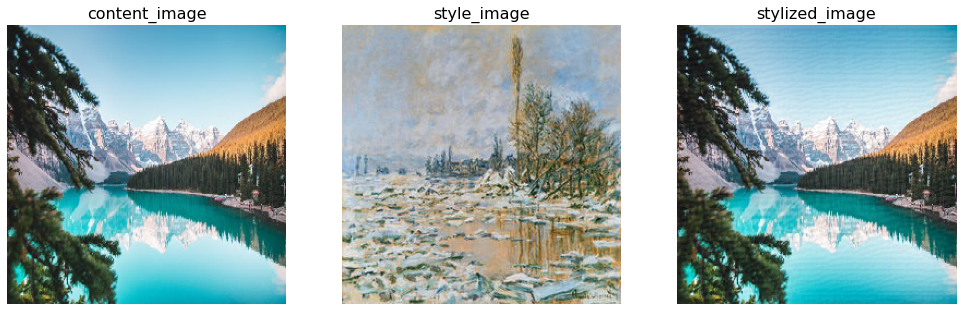

In [ ]:

if(style_img.ndim !=4):
  style_img = np.expand_dims(style_img, axis=0)

style_targets = loaded_base(style_img)['style']
content_img = np.asarray(content_img)
if(content_img.ndim !=4):
  content_img = np.expand_dims(content_img, axis=0)
content_targets = loaded_base(content_img)['content']
generate_image = tf.Variable(content_img)
opt =tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
train_step(generate_image)



generate_image=generate_image.read_value().numpy()

print((content_img == generate_image).all())
# This code snippet checks if all the pixel values of the content_img and generate_image tensors are the same

plt.figure(figsize = (17,10))
plt.subplot(1,3,1)
plt.title("content_image",size = 16)
plt.imshow(np.squeeze(content_img))
plt.axis('off')
plt.subplot(1,3,2)
plt.title("style_image",size = 16)
plt.imshow(np.squeeze(style_img))
plt.axis('off')

plt.subplot(1,3,3)
plt.title("stylized_image",size = 16)
plt.imshow(np.squeeze(generate_image))
plt.axis('off')
plt.show()




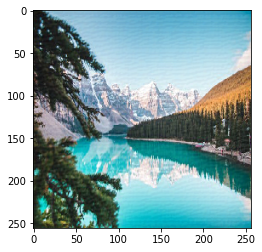

In [ ]:
np.resize(generate_image,(320,320,3))
plt.imshow(generate_image[0])